In [1]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
import time
import numpy as np
import math
from skimage.util import random_noise
from skimage.transform import rotate

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
IMG_SIZE = 224
LBL = dict(zip(['B_BSMUT1', 'B_CLEV5B', 'B_DISTO', 'B_GRMEND', 'B_HDBARL',
       'B_PICKLD', 'B_SKINED', 'B_SOUND', 'B_SPRTED', 'B_SPTMLD',
       'O_GROAT', 'O_HDOATS', 'O_SEPAFF', 'O_SOUND', 'O_SPOTMA',
       'WD_RADPODS', 'WD_RYEGRASS', 'WD_SPEARGRASS', 'WD_WILDOATS',
       'W_DISTO', 'W_FLDFUN', 'W_INSDA2', 'W_PICKLE', 'W_SEVERE',
       'W_SOUND', 'W_SPROUT', 'W_STAIND', 'W_WHITEG'], range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

model_version = '001'

# Work around for a SageMaker path issue
# (see https://github.com/aws/sagemaker-python-sdk/issues/648)
# WARNING - removing this may cause the submission process to fail
#if abspath("D:/Ramdhan/Unearth/visual-grain-analysis") not in sys.path:
 #   sys.path.append(abspath("D:/Ramdhan/Unearth/visual-grain-analysis"))

def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def get_subfolders(directory):
    subfolders = os.listdir(directory)
    subfolders.sort()
    return subfolders

def save_class_list(class_list):
    class_list.sort()
    target=open("class_list.txt",'w')
    for c in class_list:
        target.write(c)
        target.write("\n")

def get_num_files(directory):
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    #img = tf.image.resize(img, (224, 224))
    img = tf.image.random_crop(img, size=[random_crop_size, random_crop_size, 3])
    img = tf.image.resize(img, (224, 224))
    return img

def noise(img):
    img = random_noise(img, mode='speckle', mean=0, var=0.05, clip=True)
    return img

def saturation(img):
    img = tf.image.random_hue(img, max_delta=0.2)
    return img

def resize_pad(img):
    #img = tf.image.resize_with_pad(img, 224, 224,method='nearest')
    img = tf.image.resize(img, (224, 224),method='nearest')
    return img

def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-180, 180)
    return rotate(image_array, random_degree, mode='edge')

def rotation_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 224, 224, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = resize_pad(batch_x[i])
            batch_crops[i] = random_rotation(batch_x[i])
        yield (batch_crops, batch_y)

def saturation_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 224, 224, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = saturation(batch_x[i])
        yield (batch_crops, batch_y)

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 224, 224, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], crop_length)
        yield (batch_crops, batch_y)
        
def noise_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 224, 224, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = noise(batch_x[i])
        yield (batch_crops, batch_y)

def train(args):
    global NUM_CLASSES
    """Train
    """
    logger.info("calling training function")

    ### Build the tensorflow dataset from downloaded files
    
    train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                       #rotation_range=180,
                                      #shear_range=args.shear,
                                      #zoom_range=2,
                                      #horizontal_flip=True,
                                      #vertical_flip=True,
                                      #fill_mode="nearest",
                                      #width_shift_range=args.shear,
                                      #height_shift_range=args.shear,
                                      #brightness_range = [0,0.1],
                                      #channel_shift_range = 0.5,
                                      #rescale=1.0 / 255,
                                       )
      

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    TRAIN_DIR = os.path.join(args['data_dir'],  'train')
    VAL_DIR = os.path.join(args['data_dir'], 'val')
    
    size = (IMG_SIZE, IMG_SIZE)
    batch_size = 32

    train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=size, batch_size=batch_size)
    samples = train_generator.samples
    train_crops = rotation_generator(train_generator)

    validation_generator = val_datagen.flow_from_directory(VAL_DIR, target_size=size, batch_size=batch_size)
    
    #ds_build_cmd = "tfds build grains --manual_dir=" + args['data_dir']
    #logger.info(ds_build_cmd)
    #os.system(ds_build_cmd)

    logger.info("Training Model")
    #strategy = tf.distribute.MirroredStrategy()
    
    #dataset_name = "grains"
    #(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "val"], with_info=True, as_supervised=True)
    class_list = get_subfolders(TRAIN_DIR)
    NUM_CLASSES = len(class_list)
    save_class_list(class_list)

    num_train_images = get_num_files(TRAIN_DIR)
    num_val_images = get_num_files(VAL_DIR)

    logger.info("number of classes is " + str(NUM_CLASSES))

    #with strategy.scope():
    #model = build_model(num_classes=NUM_CLASSES)
    model = build_model_attention2(num_classes=NUM_CLASSES)
    #model = build_model2(dropout=0.5, fc_layers=[512], num_classes=NUM_CLASSES)
    filename = 'best.h5'
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
    checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, mode='max')
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, mode= 'min', min_delta=0.00)
    lr_schedule= get_cosine_schedule_with_warmup(lr=0.001, num_warmup_steps=4, num_training_steps=25)

    # This comes from an environment variable so we can set it to 1 for our
    # development pipeline. Feel free to set this to any value.
    weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))

    history = model.fit(train_crops, epochs=25, validation_data=validation_generator, shuffle=True,
                        callbacks=[stop, checkpoint,lr_schedule],steps_per_epoch=samples/batch_size,
              verbose=1, class_weight=weights
                        #, workers=0, steps_per_epoch=num_train_images // batch_size, 
        #, validation_steps=num_val_images // batch_size,shuffle=True
                       )
    #save_model(model,args['model_dir'])
    #save_model(model,filename)
    
    return history

def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

def build_model_attention(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")
    for layer in model.layers[:-1]:
        layer.trainable = False
    #model.trainable = False
    pt_features = model(inputs)
    pt_depth = model.get_output_shape_at(0)[-1]
    bn_features = layers.BatchNormalization()(pt_features)
    
     # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = layers.Conv2D(64, kernel_size = (1, 1), padding = 'same', activation = 'swish')(layers.Dropout(0.5)(bn_features))
    attn_layer = layers.Conv2D(16, kernel_size = (1, 1), padding = 'same', activation = 'swish')(attn_layer)
    attn_layer = layers.Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'swish')(attn_layer)
    attn_layer = layers.Conv2D(1, kernel_size = (1, 1), padding = 'valid', activation = 'sigmoid')(attn_layer)
    
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = layers.Conv2D(pt_depth,kernel_size=(1,1),padding = 'same', activation='linear',use_bias = False,weights = [up_c2_w] )
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = layers.multiply([attn_layer, bn_features])
    gap_features = layers.GlobalAveragePooling2D()(mask_features)
    gap_mask = layers.GlobalAveragePooling2D()(attn_layer)
    
     # To account for missing values from the attention model
    gap = layers.Lambda(lambda x: x[0] / x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = layers.Dropout(0.5)(gap)
    dr_steps = layers.Dropout(0.25)(tf.keras.layers.Dense(128, activation = 'swish')(gap_dr))
    
    concat = layers.BatchNormalization()(dr_steps)
    concat = layers.Dense(512, activation = 'swish')(concat)        
    concat = layers.Dropout(0.15)(concat)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred",dtype='float32')(concat)

    model = tf.keras.Model([inputs], [outputs], name="EfficientNet")
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    return model

def build_model_attention2(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")
    #for layer in model.layers[:-1]:
        #layer.trainable = False
    model.trainable = False
    pt_features = model(inputs)
    pt_depth = model.get_output_shape_at(0)[-1]
    bn_features = layers.BatchNormalization()(pt_features)
    
     # here we do an attention mechanism to turn pixels in the GAP on an off   
    attn_layer = layers.Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
    attn_layer = layers.Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = layers.LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
    
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 =  layers.Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features =  layers.multiply([attn_layer, bn_features])
    gap_features =  layers.GlobalAveragePooling2D()(mask_features)
    gap_mask =  layers.GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap =  layers.Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr =  layers.Dropout(0.5)(gap)
    dr_steps =  layers.Dropout(0.25)( layers.Dense(1024, activation = 'elu')(gap_dr))
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred",dtype='float32')(dr_steps)

    model = tf.keras.Model([inputs], [outputs], name="EfficientNet")
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    return model

def save_model(model, model_dir):
    """Save model to a binary file.

    This function must write the model to disk in a format that can
    be loaded from the model_fn.

    WARNING - modifying this function may cause the submission process to fail.
    """
    #sm_model_dir = os.path.join(model_dir, model_version)
    sm_model_dir = model_dir
    if (not os.path.isdir(sm_model_dir)):
        os.makedirs(sm_model_dir)
        
    logger.info(f" model dir is {model_dir}")
    model.save(sm_model_dir)
    
    modelPath = os.path.join(sm_model_dir, 'output')
    if (not os.path.isdir(modelPath)):
        os.makedirs(modelPath)
    #if (not os.path.isdir(sm_model_dir + '/code')):
        #os.makedirs(sm_model_dir + '/code')

    # Move inference.py so it gets picked up in the archive
    #copyfile('/content/sample_data/inference.py', sm_model_dir + '/code/inference.py')
    #copyfile('/content/sample_data/inference-requirements.txt', sm_model_dir+ '/code/requirements.txt')

    with tarfile.open(os.path.join(modelPath, 'model.tar.gz'), mode='x:gz') as archive:
        archive.add(sm_model_dir, recursive=True)

def model_fn(model_dir):
    """Load model from binary file.

    This function loads the model from disk. It is called by SageMaker.

    WARNING - modifying this function may case the submission process to fail.
    """
    #model_filepath = os.path.join(model_dir,  model_version)
    #logger.info("loading model from " + model_filepath)
    model = keras.models.load_model('best.h5',custom_objects={'acc_grain':acc_grain},compile=False)
    return model

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
if __name__ == "__main__":
    """Training Main

    The main function is called by both Unearthed's SageMaker pipeline and the
    Unearthed CLI's "unearthed train" command.
    
    WARNING - modifying this function may cause the submission process to fail.

    The main function must call preprocess, arrange th
    """
    
    args = {'model_dir': "D:/Ramdhan/Unearth/visual-grain-analysis/models/",
           'data_dir' : "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/"}
    start = time.time()
    history = train(args)
    print('duration run',(time.time()-start)/60/60,' hours')

INFO:__main__:calling training function


Found 19182 images belonging to 28 classes.


INFO:__main__:Training Model


Found 7648 images belonging to 28 classes.


INFO:__main__:number of classes is 28



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/25
600/599 [==============================] - ETA: 0s - loss: 23.5603 - acc_grain: 0.0244
Epoch 00001: val_acc_grain improved from -inf to 0.01265, saving model to best.h5
600/599 [==============================] - 385s 642ms/step - loss: 23.5603 - acc_grain: 0.0244 - val_loss: 3.5856 - val_acc_grain: 0.0126

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 2/25
600/599 [==============================] - ETA: 0s - loss: 2.8444 - acc_grain: 0.9001
Epoch 00002: val_acc_grain improved from 0.01265 to 0.94895, saving model to best.h5
600/599 [==============================] - 383s 639ms/step - loss: 2.8444 - acc_grain: 0.9001 - val_loss: 1.2337 - val_acc_grain: 0.9490

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 3/25
600/599 [==============================] - ETA: 0s - loss: 1.8593 - acc_grain: 0.9280
Epoch 00003: val_acc_grain improved from 0.94895 to 0.9516

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "C:\Users\Owner\Anaconda3\envs\object_detection_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-f940733bccd2>", line 15, in <module>
    history = train(args)
  File "<ipython-input-2-79d3459c9e51>", line 197, in train
    verbose=1, class_weight=weights
  File "C:\Users\Owner\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\Owner\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "C:\Users\Owner\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py", line 806, in train_function
    return step_function(self, iterator)
  File "C:\Users\Owner\AppData\Roaming\Python\Python3

KeyboardInterrupt: 

NameError: name 'history' is not defined

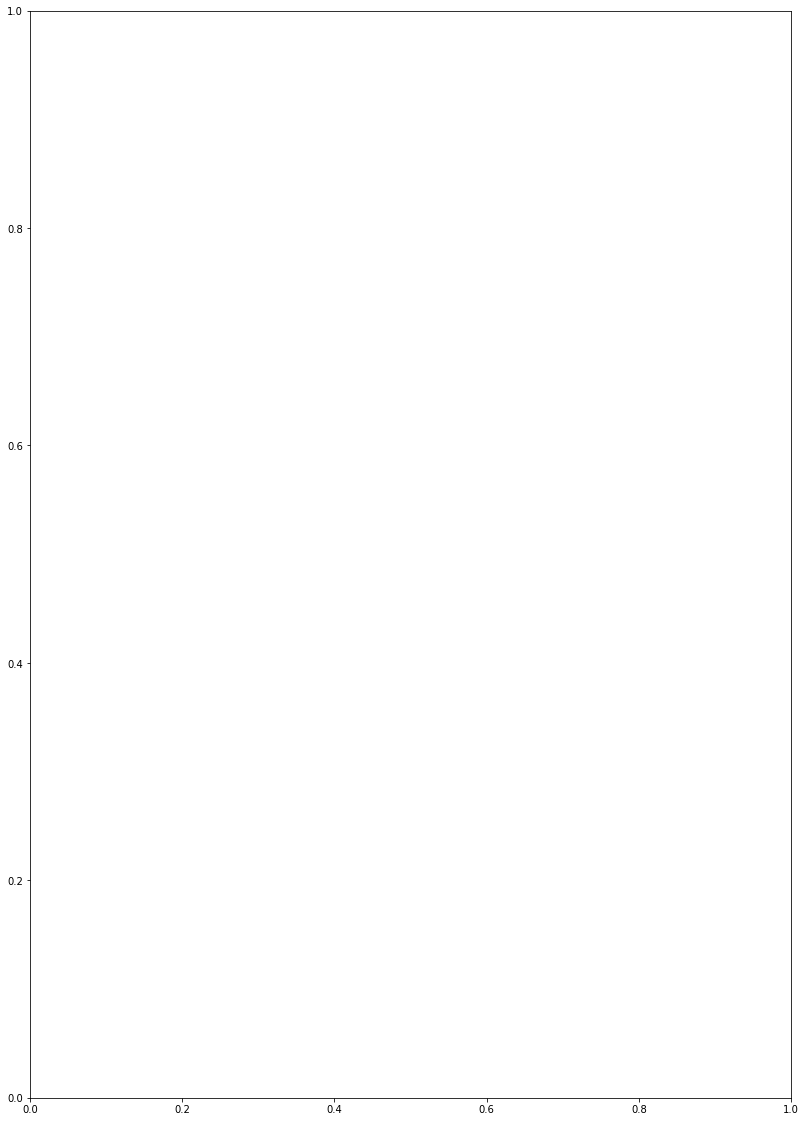

In [1]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

INFO:__main__:loading the model
INFO:__main__:Reading the test set
INFO:__main__:predictions have shape of (7648, 9)


Accuracy Score:0.9714785826952912
Duration Run 0.1071839827961392  hours


In [13]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

               precision    recall  f1-score   support

     B_BSMUT1       0.99      0.83      0.90       105
     B_CLEV5B       0.95      0.37      0.53       100
      B_DISTO       0.86      0.37      0.52       100
     B_GRMEND       0.95      0.47      0.63        88
     B_HDBARL       1.00      0.03      0.06        30
     B_PICKLD       1.00      0.28      0.44        92
     B_SKINED       0.97      0.35      0.52        88
      B_SOUND       0.79      1.00      0.88      1653
     B_SPRTED       0.98      0.89      0.93        93
     B_SPTMLD       0.93      0.22      0.36       112
      O_GROAT       0.98      0.62      0.76        90
     O_HDOATS       0.91      0.10      0.18        99
     O_SEPAFF       0.84      0.61      0.71       109
      O_SOUND       0.90      1.00      0.95      1988
     O_SPOTMA       0.89      0.23      0.37       103
   WD_RADPODS       1.00      0.97      0.98        94
  WD_RYEGRASS       0.99      0.93      0.96        87
WD_SPEARG

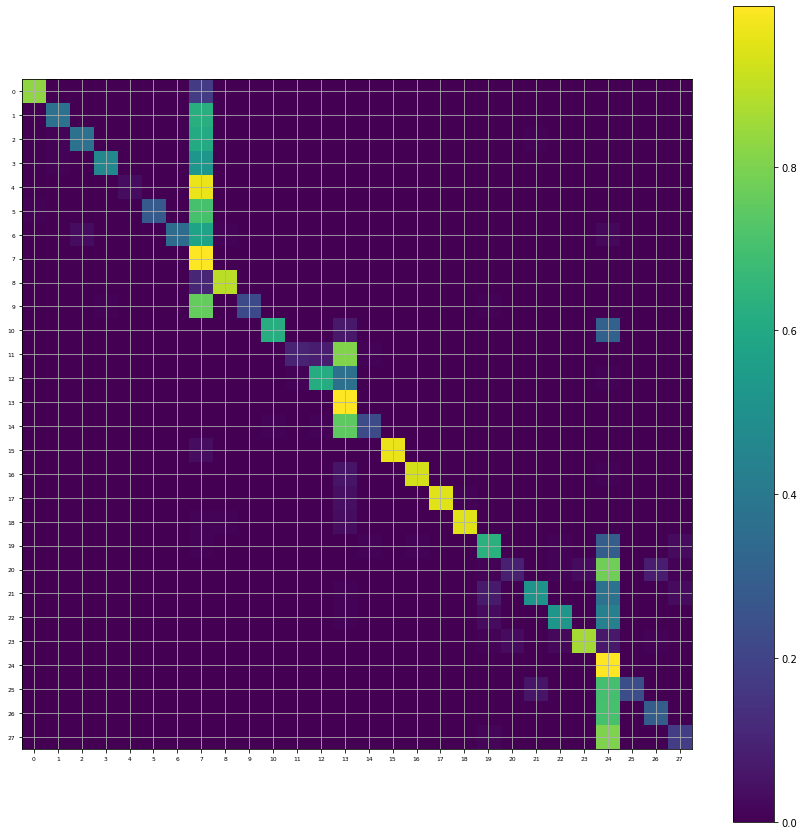

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [ ]:
from keras_preprocessing import image

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip